In [2]:
# Configuration Cell
import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from torchmetrics.classification import Accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

# Configuration
PATCH_SIZE = [4, 4]
EMBED_DIM = 96
DEPTHS = [2, 2, 6, 2]
NUM_HEADS = [3, 6, 12, 24]
WINDOW_SIZE = [7, 7]
STOCHASTIC_DEPTH_PROB = 0.2
IMAGE_SIZE = 224
NUM_CLASSES = 3  # Changed to 3 classes
BATCH_SIZE = 32
EPOCHS = 30
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset"  # Update this path

# Paths
CHECKPOINT_PATH = "C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset\\checkpoints"
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

In [4]:
# Data Preparation Cell
# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = ImageFolder(
    os.path.join("C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset\\The IQ-OTHNCCD lung cancer dataset", 'train'),
    transform=train_transform
)

val_dataset = ImageFolder(
    os.path.join("C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset\\The IQ-OTHNCCD lung cancer dataset", 'val'),
    transform=val_transform
)

test_dataset = ImageFolder(
    os.path.join("C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset\\The IQ-OTHNCCD lung cancer dataset", 'test'),
    transform=val_transform
)

# Class names
class_names = train_dataset.classes

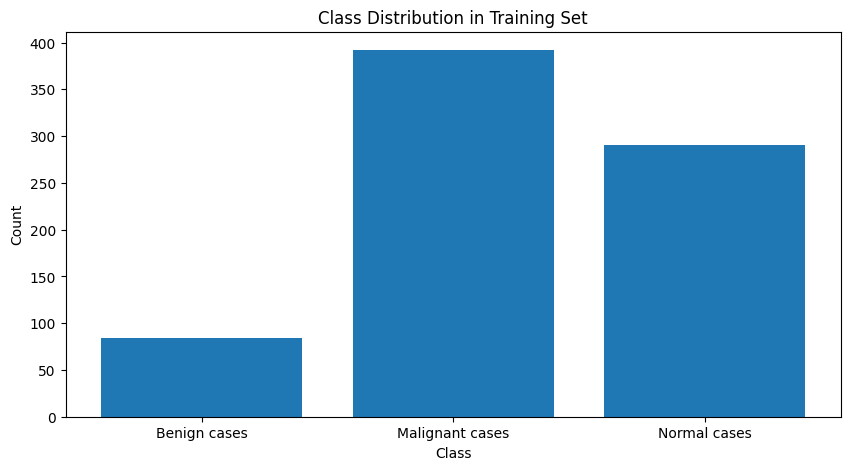

In [5]:
# Data Visualization Cell
def plot_class_distribution():
    counts = [len([x for x in train_dataset.targets if x == c]) for c in range(NUM_CLASSES)]
    plt.figure(figsize=(10, 5))
    plt.bar(class_names, counts)
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution()

In [6]:
# Model Definition Cell
from torchvision.models.swin_transformer import SwinTransformer

class LungCancerModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = SwinTransformer(
            patch_size=PATCH_SIZE,
            embed_dim=EMBED_DIM,
            depths=DEPTHS,
            num_heads=NUM_HEADS,
            window_size=WINDOW_SIZE,
            num_classes=NUM_CLASSES,
            stochastic_depth_prob=STOCHASTIC_DEPTH_PROB
        )
        
        self.train_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.val_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)
        self.test_acc = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.train_acc(logits.softmax(1), y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.val_acc(logits.softmax(1), y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.CrossEntropyLoss()(logits, y)
        self.test_acc(logits.softmax(1), y)
        self.log("test_loss", loss)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=0.05)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        return [optimizer], [scheduler]

In [7]:
# Training Cell
# Initialize model
model = LungCancerModel()

# Callbacks
checkpoint = ModelCheckpoint(
    dirpath=CHECKPOINT_PATH,
    filename="best-model",
    monitor="val_acc",
    mode="max"
)

early_stop = EarlyStopping(
    monitor="val_acc",
    patience=5,
    mode="max"
)

# Trainer
trainer = Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=EPOCHS,
    callbacks=[checkpoint, early_stop],
    log_every_n_steps=10
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Train
trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: c:\Users\DELL 5540\Desktop\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\lightning_logs

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | SwinTransformer    | 27.5 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
27.5 M    Trainable params
0         Non-trainable params
27.5 M    Total params
110.087   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
# Testing Cell
# Load best model
best_model = LungCancerModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

# Test loader
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Test
trainer.test(best_model, test_loader)

C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.759036123752594     │
│         test_loss         │    0.6974281072616577     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6974281072616577, 'test_acc': 0.759036123752594}]

In [13]:
# Inference Cell
from PIL import Image

def predict(image_path):
    # Preprocess
    img = Image.open(image_path).convert('RGB')
    img = val_transform(img).unsqueeze(0)
    
    # Predict
    best_model.eval()
    with torch.no_grad():
        probs = torch.softmax(best_model(img), 1)[0]
    
    # Format results
    return {class_names[i]: f"{probs[i].item():.2%}" for i in range(NUM_CLASSES)}

# Example usage
sample_image = "C:\\Users\\DELL 5540\\Desktop\\AI-Diagnostics-for-Predicting-Bone-Metastasis-in-Lung-Cancer-Patients-main\\archive\\The IQ-OTHNCCD lung cancer dataset\\The IQ-OTHNCCD lung cancer dataset\\test\\Malignant cases\\Malignant case (1).jpg"  # Replace with actual path
predict(sample_image)

{'Benign cases': '7.18%',
 'Malignant cases': '75.57%',
 'Normal cases': '17.24%'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


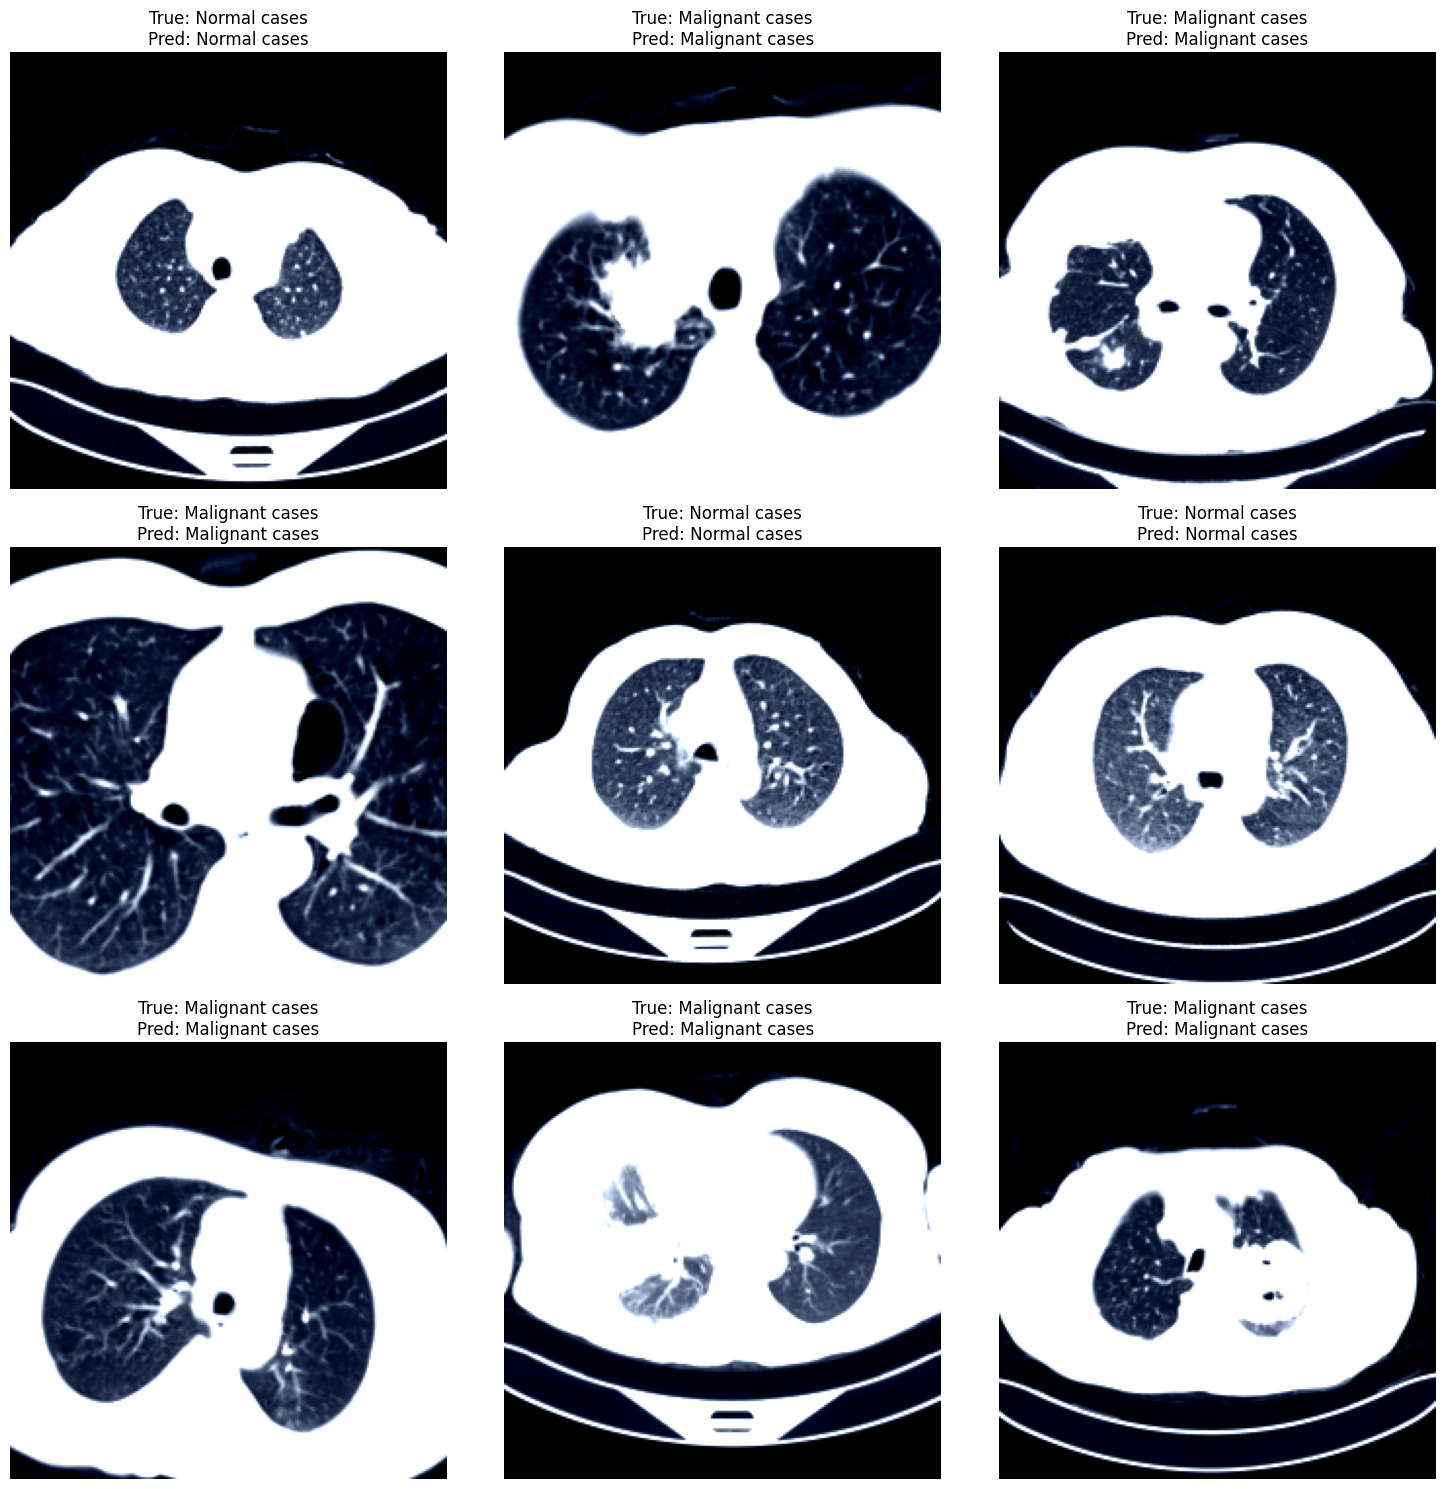

In [14]:
# Visualization Cell
def plot_predictions(num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        # Get random test image
        idx = np.random.randint(len(test_dataset))
        img, true_label = test_dataset[idx]
        
        # Predict
        with torch.no_grad():
            logits = best_model(img.unsqueeze(0))
            pred_label = torch.argmax(logits).item()
        
        # Plot
        plt.subplot(3, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions()

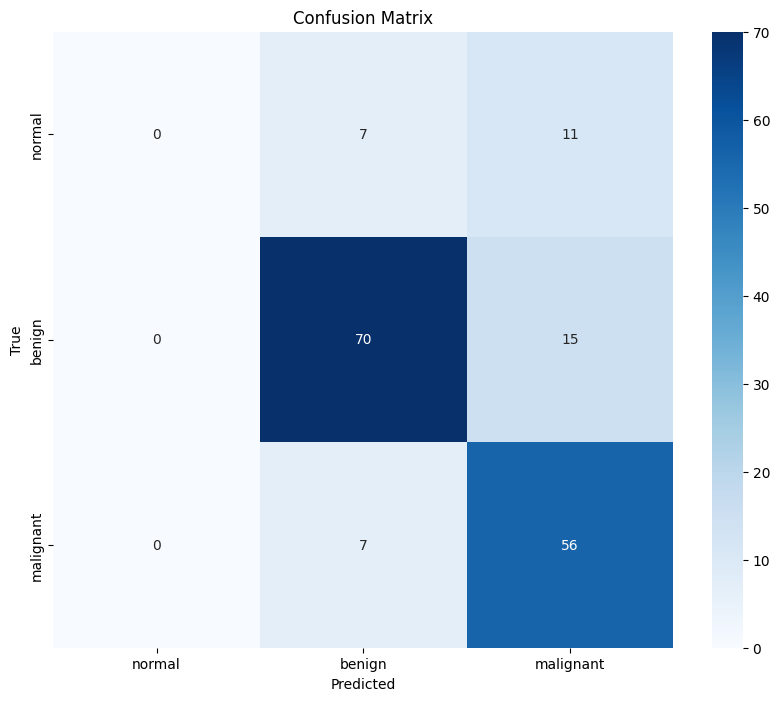

Classification Report:
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        18
      benign       0.83      0.82      0.83        85
   malignant       0.68      0.89      0.77        63

    accuracy                           0.76       166
   macro avg       0.51      0.57      0.53       166
weighted avg       0.69      0.76      0.72       166



c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Program Files\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# Cell 3: Confusion Matrix and Classification Report (run after testing)
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix_and_report(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))

# Usage - replace with your actual class names
class_names = ['normal', 'benign', 'malignant']
plot_confusion_matrix_and_report(best_model, test_loader, class_names)